In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import wbgapi as wb

import country_converter as coco
import logging
coco_logger = coco.logging.getLogger()
coco_logger.setLevel(logging.CRITICAL)



In [2]:
mailto = 'juan@alperin.ca'

In [3]:
import plotly.express as px

Note: Slightly different code was used for the first 3 figures in the paper. This code will create the figures using all data (no filters) and using the most recent data (not the snapshot). 

Essesnce of the code remains unchanged

In [4]:
def get_top_n(params, n=20):
    top_keys = []
    url = "https://api.openalex.org/works"
    r = requests.get(url, params=params)
    buckets = r.json()['group_by']
    for bucket in buckets:
        key = bucket['key']
        if key != 'unknown':
            top_keys.append(bucket['key'])
        if len(top_keys) == n:
            return top_keys
    return top_keys

def get_params(group_by, filters):
    params = {
        'mailto': mailto,
        'group_by': group_by,
    }
    if filters:
        params['filter'] = ','.join([f'{k}:{v}' for k, v in filters.items()])
    return params

def get_counts_by_year(group_by, filters=None, min_year=2000, max_year=2022, top_n=None):
    data = []
    url = "https://api.openalex.org/works"
    if filters is None:
        filters = {}
    for year in range(min_year,max_year+1):
        filters.update({'publication_year': year})
        params = get_params(group_by, filters)
        r = requests.get(url, params=params)
        group_by_results = r.json()['group_by']
        for bucket in group_by_results:
            data.append({
                'year': year,
                'key': bucket['key'],
                'key_display_name': bucket['key_display_name'],
                'n_works': bucket['count'],
            })
    df = pd.DataFrame(data)
    if top_n is not None:
        del filters['publication_year']
        params = get_params(group_by, filters)
        top_keys = get_top_n(params, n=top_n)
        df = df[df['key'].isin(top_keys)]
    return df

In [5]:
group_by = 'type'
df_work_type_by_year = get_counts_by_year(group_by)

In [6]:
group_by = 'primary_location.source.type'
df_article_source_type_by_year = get_counts_by_year(group_by, {'type': 'article'})
df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.map(lambda x: 'article-%s' % x)

top_3_types = set(df_article_source_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(3).index)

df_article_source_type_by_year['key_display_name'] = df_article_source_type_by_year.key_display_name.map(lambda x: x if x in top_3_types else 'article-other')
df_article_source_type_by_year


,year,key,key_display_name,n_works
0,2000,https://openalex.org/source-types/journal,article-journal,2140886
1,2000,https://openalex.org/source-types/repository,article-repository,139553
2,2000,https://openalex.org/source-types/conference,article-conference,14944
3,2000,https://openalex.org/source-types/book%20series,article-other,2459
4,2000,https://openalex.org/source-types/other,article-other,366
...,...,...,...,...
133,2022,https://openalex.org/source-types/repository,article-repository,423127
134,2022,https://openalex.org/source-types/conference,article-conference,233312
135,2022,https://openalex.org/source-types/book%20series,article-other,6694
136,2022,https://openalex.org/source-types/ebook%20plat...,article-other,8


In [7]:
tmp = df_work_type_by_year[df_work_type_by_year.key_display_name == 'article'].merge(df_article_source_type_by_year.groupby('year').sum(), left_on='year', right_on='year')
tmp['n_works'] = tmp['n_works_x'] - tmp['n_works_y']
tmp = tmp[['year', 'n_works']]
tmp['key'] = 'https://openalex.org/source-types/unknown'
tmp['key_display_name'] = 'article-unknown'
df_article_source_type_by_year = pd.concat([df_article_source_type_by_year, tmp])
del tmp


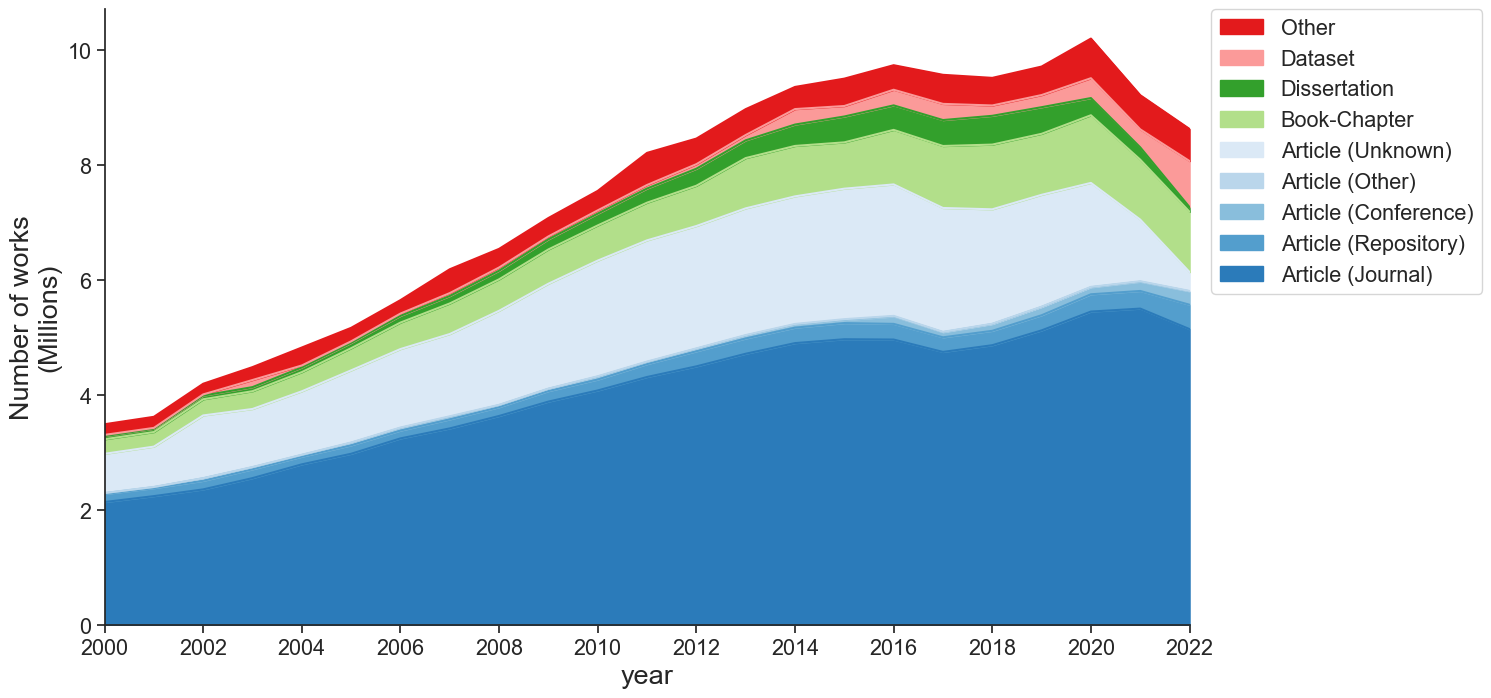

In [8]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
blues = list(reversed(sns.color_palette("Blues")[0:5]))
color = blues + sns.color_palette("Paired")[2:]

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

top_5_types = set(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().nlargest(5).index)

data = df_work_type_by_year
data['key_display_name'] = data.key_display_name.map(lambda x: x if x in top_5_types else 'other')
# data.loc['key_display_name'] = data.key.map(lambda x: x if x != 'https://openalex.org/types/other' else 'other')


data = data[data.key_display_name != 'article']
data = pd.concat([data, df_article_source_type_by_year])

data = data.groupby(['year', 'key_display_name'])['n_works'].sum().reset_index()
data['n_works'] = data.n_works.divide(1000000)
# data.groupby('key_display_name').sum().sort_values('n_works', ascending=False).index
order = ['article-journal', 'article-repository', 'article-conference', 'article-other', 'article-unknown', 'book-chapter', 'dissertation', 'dataset', 'other']
data.pivot(index='year', columns='key_display_name', values='n_works')[order].plot(kind='area', color=color, ax=ax)

ax.set_ylabel('Number of works\n(Millions)')
ax.set_xticks(range(2000,2023,2))
ax.set_xlim([2000, 2022])



handles, labels = plt.gca().get_legend_handles_labels()
def format_labels(l):
    if l.startswith('article'):
        l = "{} ({})".format(l.split('-')[0], l.split('-')[1])
    return l.title()


plt.legend(reversed(handles), map(format_labels, reversed(labels)), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# plt.tight_layout()
# plt.savefig('figures/Figure 1. Number of Works per Year by Type and Subtype - from latest.png')



In [9]:
p_articles = df_work_type_by_year.groupby('key_display_name').sum()['n_works'].divide(df_work_type_by_year.groupby('key_display_name')['n_works'].sum().sum()).multiply(100)['article']
p_journal_articles = (df_article_source_type_by_year.groupby('key_display_name').sum()['n_works'] / df_article_source_type_by_year.groupby('key_display_name')['n_works'].sum().sum() * 100)['article-journal']

print("There are {:.1f}M works in OpenAlex published between 2000 and 2022, with a peak of {:.1f}M works published in {}.".
      format(df_work_type_by_year['n_works'].sum()/1000000,  df_work_type_by_year.groupby('year')['n_works'].sum().max()/1000000, df_work_type_by_year.groupby('year')['n_works'].sum().idxmax()))
print("The majority ({:.0f}%) of these works are classified as articles and, of these articles, the majority ({:.0f}%) are found in journals.".format(p_articles, p_journal_articles))


There are 173.5M works in OpenAlex published between 2000 and 2022, with a peak of 10.6M works published in 2020.
The majority (78%) of these works are classified as articles and, of these articles, the majority (68%) are found in journals.


In [10]:
p_articles = (df_work_type_by_year[df_work_type_by_year.year >= 2013].groupby('key_display_name').sum()['n_works'] / df_work_type_by_year[df_work_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum().sum() * 100)['article']
p_journal_articles = (df_article_source_type_by_year[df_article_source_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum() / df_article_source_type_by_year[df_article_source_type_by_year.year >= 2013].groupby('key_display_name')['n_works'].sum().sum() * 100)['article-journal']

print("The proportion classified as articles changes only slightly (to {:.0f}%) when considering only the most recent 10 years.".format(p_articles))


The proportion classified as articles changes only slightly (to 75%) when considering only the most recent 10 years.


In [11]:
group_by = 'authorships.countries'
df_work_type_by_year = get_counts_by_year(group_by, top_n=10)

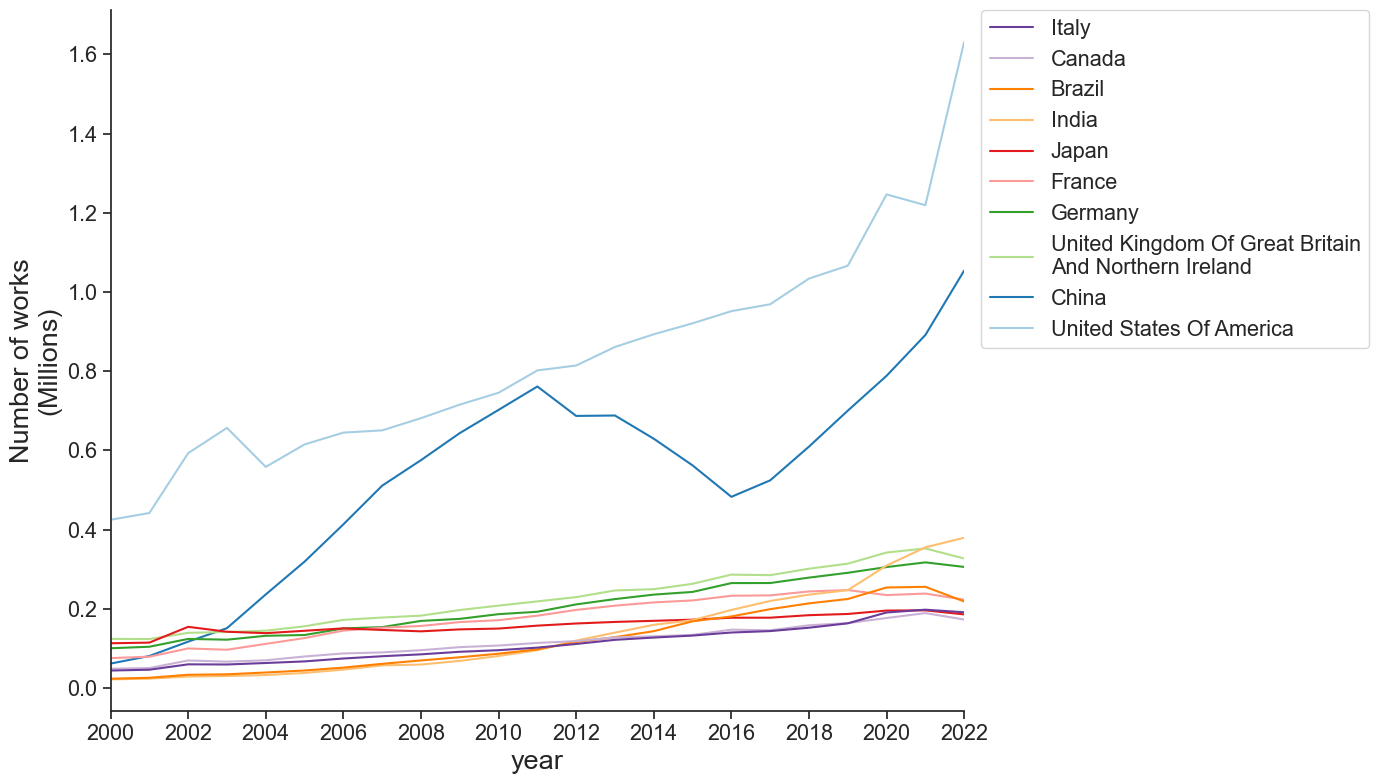

In [12]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 * font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)

color = sns.color_palette("Paired")

fig, ax = plt.subplots(1, 1, figsize=(14, 8))


data = df_work_type_by_year
data = data.groupby(['year', 'key_display_name'])['n_works'].sum().reset_index()
data['n_works'] = data.n_works.divide(1000000)
order = list(data.groupby('key_display_name').sum().sort_values('n_works', ascending=False).index)
data.pivot(index='year', columns='key_display_name', values='n_works')[order].plot(kind='line', color=color, ax=ax)


ax.set_ylabel('Number of works\n(Millions)')
ax.set_xticks(range(2000,2023,2))
ax.set_xlim([2000, 2022])

handles, labels = plt.gca().get_legend_handles_labels()
def format_labels(l):
    return l.replace(' and', '\nand').title()

plt.legend(reversed(handles), map(format_labels, reversed(labels)), bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('figures/Figure 2. Number of Works per Year by Country - from latest.png')



In [13]:
def read_openalex(field): 
    all_years = pd.read_excel('OpenAlex.xlsx', sheet_name='{}_all_years'.format(field)[0:31], engine='openpyxl')
    all_years = all_years.set_index(field).dropna()
    
    last10 = pd.read_excel('OpenAlex.xlsx', sheet_name='{}_2013-2022'.format(field)[0:31], engine='openpyxl')
    last10 = last10.set_index(field).dropna()
    return all_years, last10

refs_all, refs_last10 = read_openalex('referenced_works_count')
cits_all, cits_last10 = read_openalex('cited_by_count')

/var/folders/4b/43vz3d191td7z4mzsgbbnf0m0000gn/T/ipykernel_15013/2031670449.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=refs_all.groupby('bin').sum().multiply(100).divide(refs_all.groupby('bin').sum().sum()).reset_index(),
/var/folders/4b/43vz3d191td7z4mzsgbbnf0m0000gn/T/ipykernel_15013/2031670449.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.barplot(data=refs_all.groupby('bin').sum().multiply(100).divide(refs_all.groupby('bin').sum().sum()).reset_index(),
/opt/anaconda3/envs/data/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observ

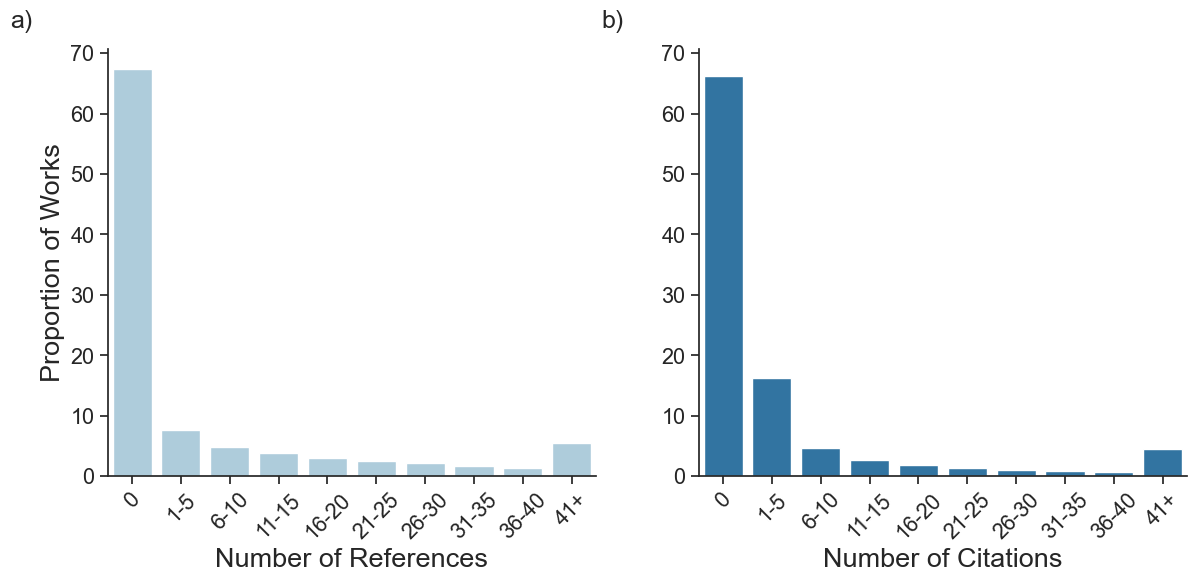

In [14]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)

color = sns.color_palette("Paired")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

bins = [0] + list(range(1,46,5)) + [np.Inf+1]
labels = [str(x) for x in bins[:-2]] + ['41+']

ax = axes[0] #[0]
ax.text(-0.2, 1.05, 'a)', transform=ax.transAxes, size=18)
refs_all['bin'] = pd.cut(refs_all.index, bins=bins, include_lowest=True, right=False, labels=labels)
sns.barplot(data=refs_all.groupby('bin').sum().multiply(100).divide(refs_all.groupby('bin').sum().sum()).reset_index(), 
            x='bin', 
            y='total',
            color=sns.color_palette("Paired")[0],
           ax=ax
)
# ax.set_title('Number of References\nAll years')
ax.set_xlabel('Number of References')

# ax = axes[0]
# refs_last10['bin'] = pd.cut(refs_last10.index, bins=bins, include_lowest=True, right=False, labels=labels)
# sns.barplot(data=refs_last10.groupby('bin').sum().multiply(100).divide(refs_last10.groupby('bin').sum().sum()).reset_index(), 
#             x='bin', 
#             y='total',
#             color=sns.color_palette("Paired")[0],
#            ax=ax
# )
# ax.set_title('Number of References\n2013–2022')
# ax.set_xlabel('Number of References')

ax=axes[1] #[0]
ax.text(-0.2, 1.05, 'b)', transform=ax.transAxes, size=18)
cits_all['bin'] = pd.cut(cits_all.index, bins=bins, include_lowest=True, right=False, labels=labels)
sns.barplot(data=cits_all.groupby('bin').sum().multiply(100).divide(cits_all.groupby('bin').sum().sum()).reset_index(), 
            x='bin', 
            y='total',
            color=sns.color_palette("Paired")[1],
           ax=ax
)
# ax.set_title('Number of Citations\nAll years')
ax.set_xlabel('Number of Citations')

# ax = axes[1]
# cits_last10['bin'] = pd.cut(cits_last10.index, bins=bins, include_lowest=True, right=False, labels=labels)
# sns.barplot(data=cits_last10.groupby('bin').sum().multiply(100).divide(cits_last10.groupby('bin').sum().sum()).reset_index(), 
#             x='bin', 
#             y='total',
#             color=sns.color_palette("Paired")[1],
#            ax=ax
# )
# ax.set_title('Number of Citations\n2013–2022')
# ax.set_xlabel('Number of Citations')

ylim = [0, max([ax.get_ylim()[1] for ax in axes])]

for ax in axes: 
    ax.set_ylim(ylim)

    ax.set_xticklabels(['0'] + ['{}-{}'.format(x, x+4) for x in range(1,40, 5)] + ['41+'], rotation=45)

    

axes[0].set_ylabel('Proportion of Works')
axes[1].set_ylabel('')
    
    
    

# for i in [0,1]:
#     ax = axes[i][0]
#     current_values = ax.get_yticks()
#     ylim = ax.get_ylim()
#     ax.set_yticklabels(['{:,.0f}'.format(x/1000000) for x in current_values])
#     ax.set_ylabel('Proportion of Works')
    
#     ax = axes[i][1]
#     ax.set_ylim(ylim)
#     ax.set_yticks(current_values)
#     ax.set_yticklabels([])
#     ax.set_ylabel('')


fig.tight_layout()
plt.savefig('figures/Figure 3. Distribution of Number of References and Citations.png', bbox_inches='tight')


In [15]:
scopus_all = None
scopus_last10 = None

def _clean_scopus_cols(df):
    prev_columns = df.columns
    columns = []
    for i in range(0,len(prev_columns), 2):
        col_name = prev_columns[i].lower().replace(' ', '_')
        columns.append(col_name)
        columns.append(col_name + '_n')

    df.columns = columns[0:len(prev_columns)]
    return df

def read_scopus(field): 
    global scopus_all, scopus_last10
    
    try: 
        assert(scopus_all.shape[0] > 1)
        assert(scopus_last10.shape[0] > 1)
    except:
        scopus_all = pd.read_excel('Scopus.xlsx', skiprows=7, sheet_name='Full_Scopus_all_years', index_col=False, engine='openpyxl')
        scopus_all = _clean_scopus_cols(scopus_all)
        scopus_last10 = pd.read_excel('Scopus.xlsx', skiprows=7, sheet_name='Full_Scopus_2013-2022', index_col=False, engine='openpyxl')
        scopus_last10 = _clean_scopus_cols(scopus_last10)
    
    all_years = scopus_all[[field, '{}_n'.format(field)]].dropna()
    all_years.set_index(field, inplace=True)
    
    last10 = scopus_last10[[field, '{}_n'.format(field)]].dropna()
    last10.set_index(field, inplace=True)    
    
    return all_years, last10

read_scopus('year')

scopus_all_N = scopus_all.year_n.sum()
scopus_last10_N = scopus_last10.year_n.sum()

In [16]:
oa_status_map = pd.read_excel('field_maps.xlsx', sheet_name='oa_status', engine='openpyxl')
oa_status_map.set_index('openalex', inplace=True)
oa_status_map = pd.Series(oa_status_map.index,index=oa_status_map.scopus).to_dict()

is_oa_all, is_oa_last10 = read_openalex('is_oa')
oa_all, oa_last10 = read_openalex('oa_status')

is_oa_all = is_oa_all[is_oa_all.index == True]
is_oa_all.index = ['open']

is_oa_last10 = is_oa_last10[is_oa_last10.index == True]
is_oa_last10.index = ['open']

oa_all = pd.concat([oa_all, is_oa_all])
oa_last10 = pd.concat([oa_last10, is_oa_last10])

sc_all, sc_last10 = read_scopus('open_access')

sc_all.loc['Closed'] = [scopus_all_N - sc_all.loc['All Open Access']['open_access_n']]
sc_all.drop(index='Green', inplace=True)
sc_all.index = sc_all.index.map(lambda x: oa_status_map[x])

sc_last10.loc['Closed'] = [scopus_last10_N - sc_last10.loc['All Open Access']['open_access_n']]
sc_last10.drop(index='Green', inplace=True)
sc_last10.index = sc_last10.index.map(lambda x: oa_status_map[x])

def prepare_oa_status(oa, sc): 
    df = oa.merge(sc, left_index=True, right_index=True)
    df.columns = ['openalex_no_scopus', 'openalex_in_scopus', 'openalex_total', 'scopus']
    del df['openalex_total']

    df = df.reindex(['open', 'gold', 'hybrid', 'bronze', 'green', 'closed'])
    return df

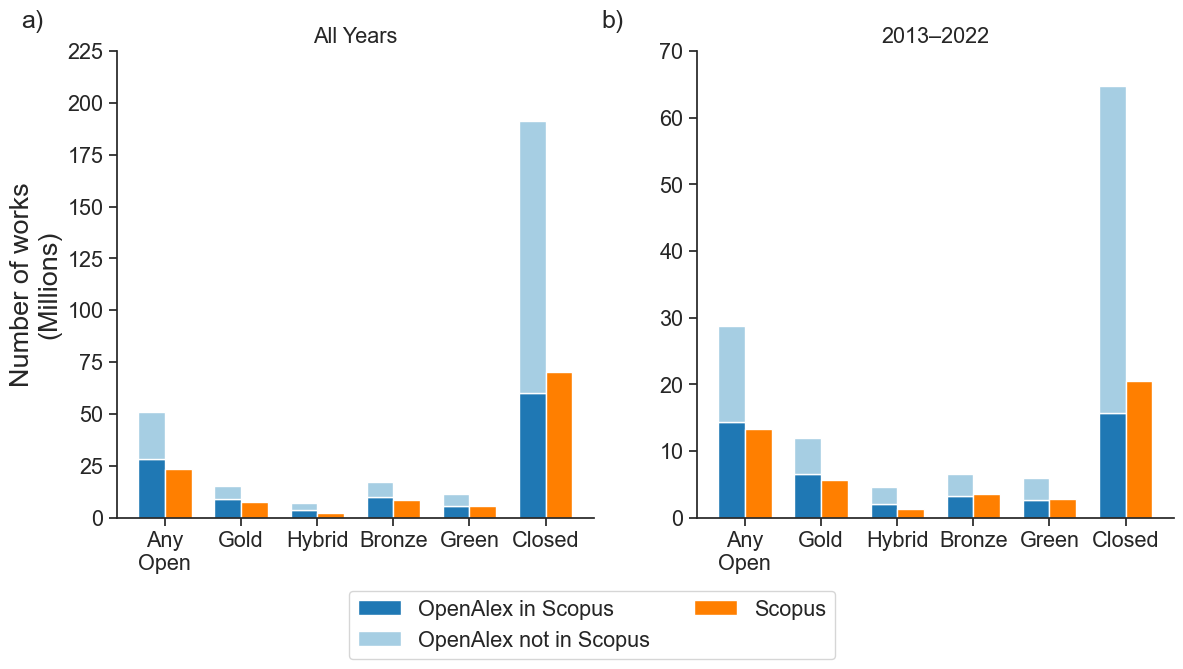

In [17]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
color=sns.color_palette("Paired")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, ax in enumerate(axes.reshape(-1)):
    if i == 0: 
        df = prepare_oa_status(oa_all, sc_all)
        ax.set_title('All Years', fontsize=12*font_scale)
    else:
        df = prepare_oa_status(oa_last10, sc_last10)
        ax.set_title('2013–2022', fontsize=12*font_scale)
        
    width = 0.35  # the width of the bars

    # Create bars for each group
    bars1 = ax.bar([x-width/2 for x in range(1,df.shape[0]+1)], df['openalex_in_scopus'], width, label='OpenAlex in Scopus', color=color[1])
    bars2 = ax.bar([x-width/2 for x in range(1,df.shape[0]+1)], df['openalex_no_scopus'], width, bottom=df['openalex_in_scopus'], label='OpenAlex not in Scopus', color=color[0])
    bars3 = ax.bar([x+width/2 for x in range(1,df.shape[0]+1)], df['scopus'], width, label='Scopus', color=color[7])

    ax.set_xticks(np.arange(1, df.shape[0]+1))
    ax.set_xticklabels([x.replace('open', 'any\nopen').title() for x in df.index])
    
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(['{:,.0f}'.format(x/1000000) for x in ax.get_yticks()])

    ax.text(-0.2, 1.05, '{})'.format('ab'[i]), transform=ax.transAxes, size=18)
    
# ylim = [0, max([ax.get_ylim()[1] for ax in axes])]
# for ax in axes: 
#     ax.set_ylim(ylim)
axes[0].set_ylabel('Number of works\n(Millions)')

# handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5, 0.02), ncol=2, loc='upper center')
# plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('figures/Figure 4. Comparison of OA Status.png', bbox_inches='tight')

In [18]:
type_map = pd.read_excel('field_maps.xlsx', sheet_name='doctype', engine='openpyxl')
type_map = type_map.iloc[:, :3]
type_map.dropna(inplace=True)
type_map = pd.Series(type_map.openalexnew.values,index=type_map.scopus).to_dict()



In [19]:
oa_doctype_all, oa_doctype_last10 = read_openalex('type')
oa_retracted_all, oa_retracted_last10 = read_openalex('is_retracted')
oa_retracted_all.index = oa_retracted_all.index.map(lambda x: 'retracted' if x == True else 'not_retracted')
oa_retracted_last10.index = oa_retracted_last10.index.map(lambda x: 'retracted' if x == True else 'not_retracted')

sc_doctype_all, sc_doctype_last10 = read_scopus('document_type')

def prepare_doctype(oa, sc, oa_retract): 
    oa['doctype'] = oa.index.map(lambda x: x if x in set(type_map.values()) else 'other')
    oa = oa.groupby('doctype').sum()   
    
    oa = pd.concat([oa, oa_retract])
    oa = oa[oa.index != 'not_retracted']
    
    sc['doctype'] = sc.index.map(lambda x: x if x in type_map.keys() else 'other')
    sc['doctype'] = sc.doctype.map(lambda x: type_map[x] if x in type_map else x.lower().replace(' ', '-'))
    sc = sc.groupby('doctype').sum()
 
    df = oa.merge(sc, how='outer', left_index=True, right_index=True).fillna(0)
    df.columns = ['openalex_no_scopus', 'openalex_in_scopus', 'openalex_total', 'scopus']
    df = df.sort_values('openalex_total', ascending=False)
    return df.astype(int)

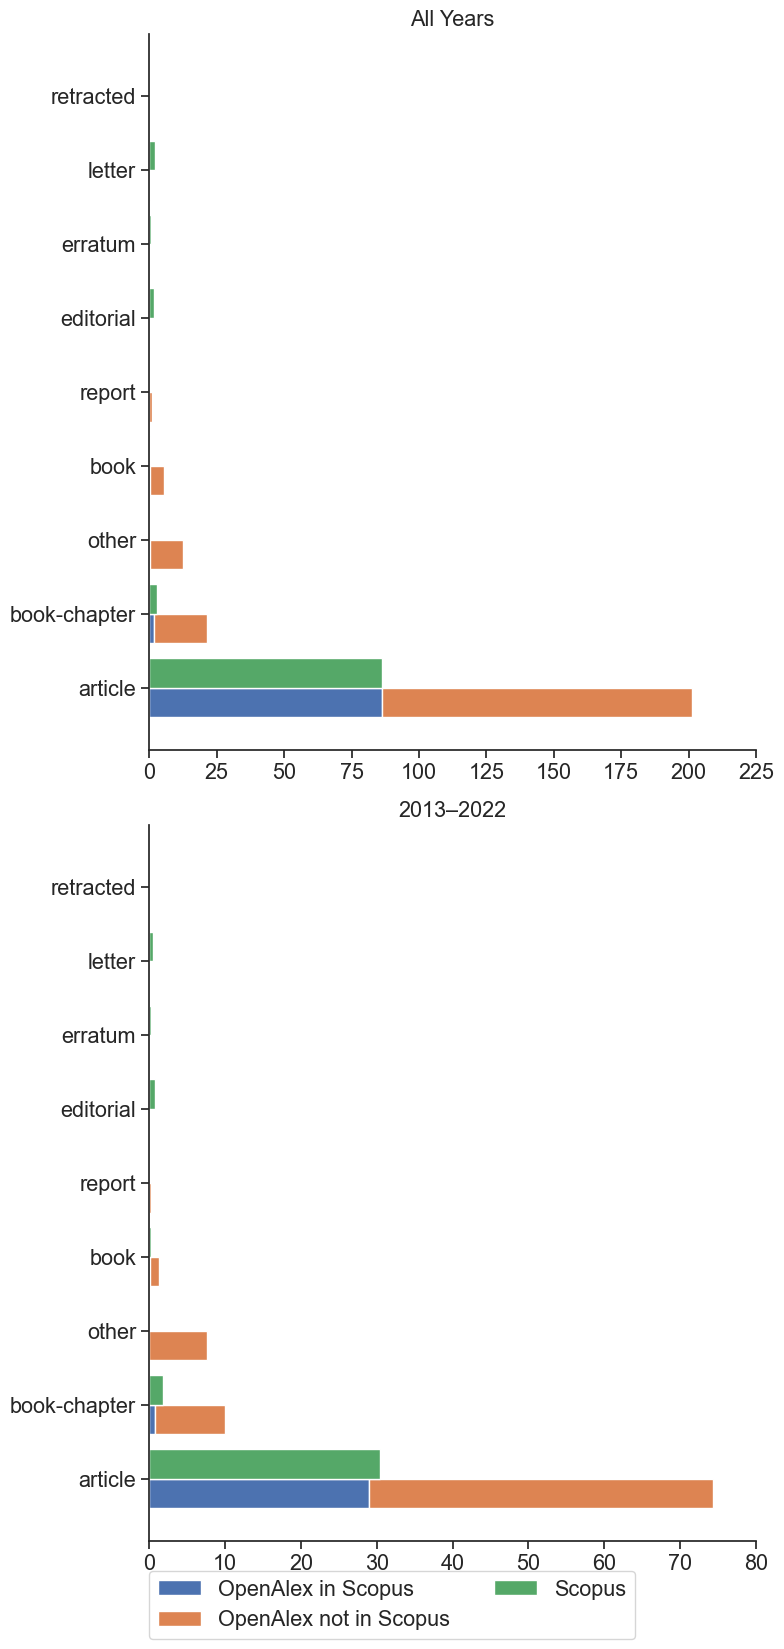

In [20]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)

fig, axes = plt.subplots(2, 1, figsize=(8, 16))

for i, ax in enumerate(axes.reshape(-1)):
    if i == 0: 
        df = prepare_doctype(oa_doctype_all, sc_doctype_all, oa_retracted_all)
        
        ax.set_title('All Years', fontsize=12*font_scale)
    else:
        df = prepare_doctype(oa_doctype_last10, sc_doctype_last10, oa_retracted_last10)
        oa_retracted_last10.index = oa_retracted_last10.index.map(lambda x: 'retracted' if x else 'not_retracted')
        
        ax.set_title('2013–2022', fontsize=12*font_scale)

#     df.drop(index='journal-article', inplace=True)
        
    width = .8  # the width of the bars

    # Create bars for each group
    bars1 = ax.barh([2*x-1-width/2 for x in range(1,df.shape[0]+1)], df['openalex_in_scopus'], width, label='OpenAlex in Scopus')
    bars2 = ax.barh([2*x-1-width/2 for x in range(1,df.shape[0]+1)], df['openalex_no_scopus'], width, left=df['openalex_in_scopus'], label='OpenAlex not in Scopus')
    bars3 = ax.barh([2*x-1+width/2 for x in range(1,df.shape[0]+1)], df['scopus'], width, label='Scopus')

    ax.set_yticks(np.arange(1, df.shape[0]*2+1, 2))
    ax.set_yticklabels(df.index)
    
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(['{:,.0f}'.format(x/1000000) for x in ax.get_xticks()])
    
# handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.5, 0.02), ncol=2, loc='upper center')
# plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
# plt.savefig('doc_type.png', bbox_inches='tight')

In [21]:

def format_doctypedf(x):
    if type(x) == int:
        return '{:,.0f}'.format(x)
    elif type(x) == float:
        return '{:.0f}%'.format(x)
    return x

df = prepare_doctype(oa_doctype_last10, sc_doctype_last10, oa_retracted_last10).astype(int)
del df['openalex_no_scopus']
df.to_clipboard()
df['diff_in_scopus'] = df['openalex_in_scopus'].subtract(df['scopus']).divide(df['scopus']).multiply(100).replace(np.inf, '-')
df['diff_total'] = df['openalex_total'].subtract(df['scopus']).divide(df['scopus']).multiply(100).replace(np.inf, '-')
df.fillna('-')
df = df[['scopus', 'openalex_in_scopus', 'diff_in_scopus', 'openalex_total', 'diff_total']]

df = df.map(format_doctypedf)
df.to_clipboard()
df.map(format_doctypedf)

,scopus,openalex_in_scopus,diff_in_scopus,openalex_total,diff_total
retracted,"14,788","29,920,076",202227%,"93,597,520",632829%
article,"30,360,256","29,032,344",-4%,"74,318,093",145%
book-chapter,"1,788,040","712,625",-60%,"10,001,177",459%
other,"1,063","21,196",1894%,"7,564,981",711563%
book,"198,963","31,055",-84%,"1,342,100",575%
report,6,4,-33%,"203,869",3397717%
editorial,"711,944","64,929",-91%,"101,525",-86%
erratum,"252,202","54,691",-78%,"60,860",-76%
letter,"513,253","13,098",-97%,"17,231",-97%
retracted,"14,788","9,866",-33%,"12,316",-17%


In [22]:
df = prepare_doctype(oa_doctype_all, sc_doctype_all, oa_retracted_all).astype(int)
del df['openalex_no_scopus']
df.to_clipboard()
df['diff_in_scopus'] = df['openalex_in_scopus'].subtract(df['scopus']).divide(df['scopus']).multiply(100).replace(np.inf, '-')
df['diff_total'] = df['openalex_total'].subtract(df['scopus']).divide(df['scopus']).multiply(100).replace(np.inf, '-')
df.fillna('-')
df = df[['scopus', 'openalex_in_scopus', 'diff_in_scopus', 'openalex_total', 'diff_total']]

df = df.map(format_doctypedf)
df.to_clipboard()
df.map(format_doctypedf)

,scopus,openalex_in_scopus,diff_in_scopus,openalex_total,diff_total
article,"86,255,829","86,396,586",0%,"201,435,514",134%
book-chapter,"2,836,598","1,593,530",-44%,"21,367,957",653%
other,"1,717","77,520",4415%,"12,566,103",731764%
book,"352,693","71,583",-80%,"5,379,368",1425%
report,"13,915",11,-100%,"822,915",5814%
editorial,"1,662,967","220,180",-87%,"293,933",-82%
erratum,"567,025","174,669",-69%,"199,123",-65%
letter,"2,269,458","43,567",-98%,"72,835",-97%
retracted,"26,728","11,966",-55%,"14,775",-45%


In [23]:
country_map = pd.read_excel('field_maps.xlsx', sheet_name='country', engine='openpyxl')
oa_country_map = country_map.iloc[:, 4:6].dropna()
oa_country_map.columns = ['openalex', 'country']
sc_country_map = country_map.iloc[:, 6:8].dropna()
sc_country_map.columns = ['scopus', 'country']

oa_country_all, oa_country_last10 = read_openalex('countries')
sc_country_all, sc_country_last10 = read_scopus('country')


In [24]:
wbdata = pd.read_excel('World Bank Country Groups.xlsx', sheet_name='List of economies', index_col='Code', engine='openpyxl')

def prepare_countries(oa, sc): 

    oa = oa.copy(deep=True)
    sc = sc.copy(deep=True)

#     cmap = country_map[['country', 'openalex']].drop_duplicates()
    cmap = pd.Series(oa_country_map.country.values,index=oa_country_map.openalex).to_dict()
    oa.index = oa.index.map(lambda x: cmap[x])
    oa = oa.reset_index().groupby('countries').sum()
    oa.index.name = 'country'
    
#     cmap = country_map[['country', 'scopus']].drop_duplicates().dropna()
    cmap = pd.Series(sc_country_map.country.values,index=sc_country_map.scopus).to_dict()
    
    sc.index = sc.index.map(lambda x: cmap[x])
    sc = sc.reset_index().groupby('country').sum()
 
    df = oa.merge(sc, how='outer', left_index=True, right_index=True).fillna(0)
    df.columns = ['openalex_no_scopus', 'openalex_in_scopus', 'openalex_total', 'scopus']
    
    df['iso3'] = coco.convert(names=df.index, to='ISO3', not_found=None)
    df = df.merge(wbdata[['Region', 'Income group']], how='left', left_on='iso3', right_index=True)

    # Fix a few not present in the WB data
    df.loc['Cook Islands', 'Region'] = 'East Asia & Pacific'
    df.loc['Cook Islands', 'Region'] = 'East Asia & Pacific'    
    df.loc['Vatican', 'Region'] = 'Europe & Central Asia'
    df.loc['Antarctica', 'Region'] = 'Antarctica'
    df.loc['Western Sahara', 'Region'] = 'Middle East & North Africa'
    df.loc['Niue', 'Region'] = 'East Asia & Pacific'

    
    df[['Region', 'Income group']] = df[['Region', 'Income group']].fillna('Unknown')
    df = df.sort_values('scopus', ascending=False)
#     del df['openalex_total']

    return df



In [25]:
var = 'openalex_in_scopus'
df = prepare_countries(oa_country_all, sc_country_all)
df = df[df['scopus'] > 0]
df.drop('_no_country', inplace=True)
df = df[df[var] > 0]

# # Add a constant to the independent variable (for intercept)
X = sm.add_constant(df[var])

# Fit the OLS model
model = sm.OLS(df.scopus, X).fit()

# Get the intercept and coefficients
intercept = model.params['const']
coefficient = model.params[var]
print()
print("Itercept: {:.0f}".format(intercept))
print("Slope: {:.2f}".format(coefficient))

model.summary()


Itercept: 25367
Slope: 1.24


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 scopus   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 2.589e+04
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          1.60e-213
Time:                        15:31:34   Log-Likelihood:                -2714.9
No. Observations:                 202   AIC:                             5434.
Df Residuals:                     200   BIC:                             5440.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.537e+04   1.21e+04      2.099      0.037    1536.263    4.92e+04
openalex_in_scopus     1.2358      0.008    160.912      0.000       1.221       1.251
==============================================================================
Omnibus:                      285.958   Durbin-Watson:                   2.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45632.347
Skew:                           5.932   Prob(JB):                         0.00
Kurtosis:                      75.670   Cond. No.                     1.62e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
data = prepare_countries(oa_country_all, sc_country_all)
data[data['scopus'] == 0]

,openalex_no_scopus,openalex_in_scopus,openalex_total,scopus,iso3,Region,Income group
country,,,,,,,
Kosovo,4287.0,4454.0,8741.0,0.0,XKX,Europe & Central Asia,Upper middle income
Bhutan,1177.0,1490.0,2667.0,0.0,BTN,South Asia,Lower middle income


Index([], dtype='object', name='country')
Index([], dtype='object', name='country')
Index([], dtype='object', name='country')
Index([], dtype='object', name='country')
Index([], dtype='object', name='country')
Index([], dtype='object', name='country')


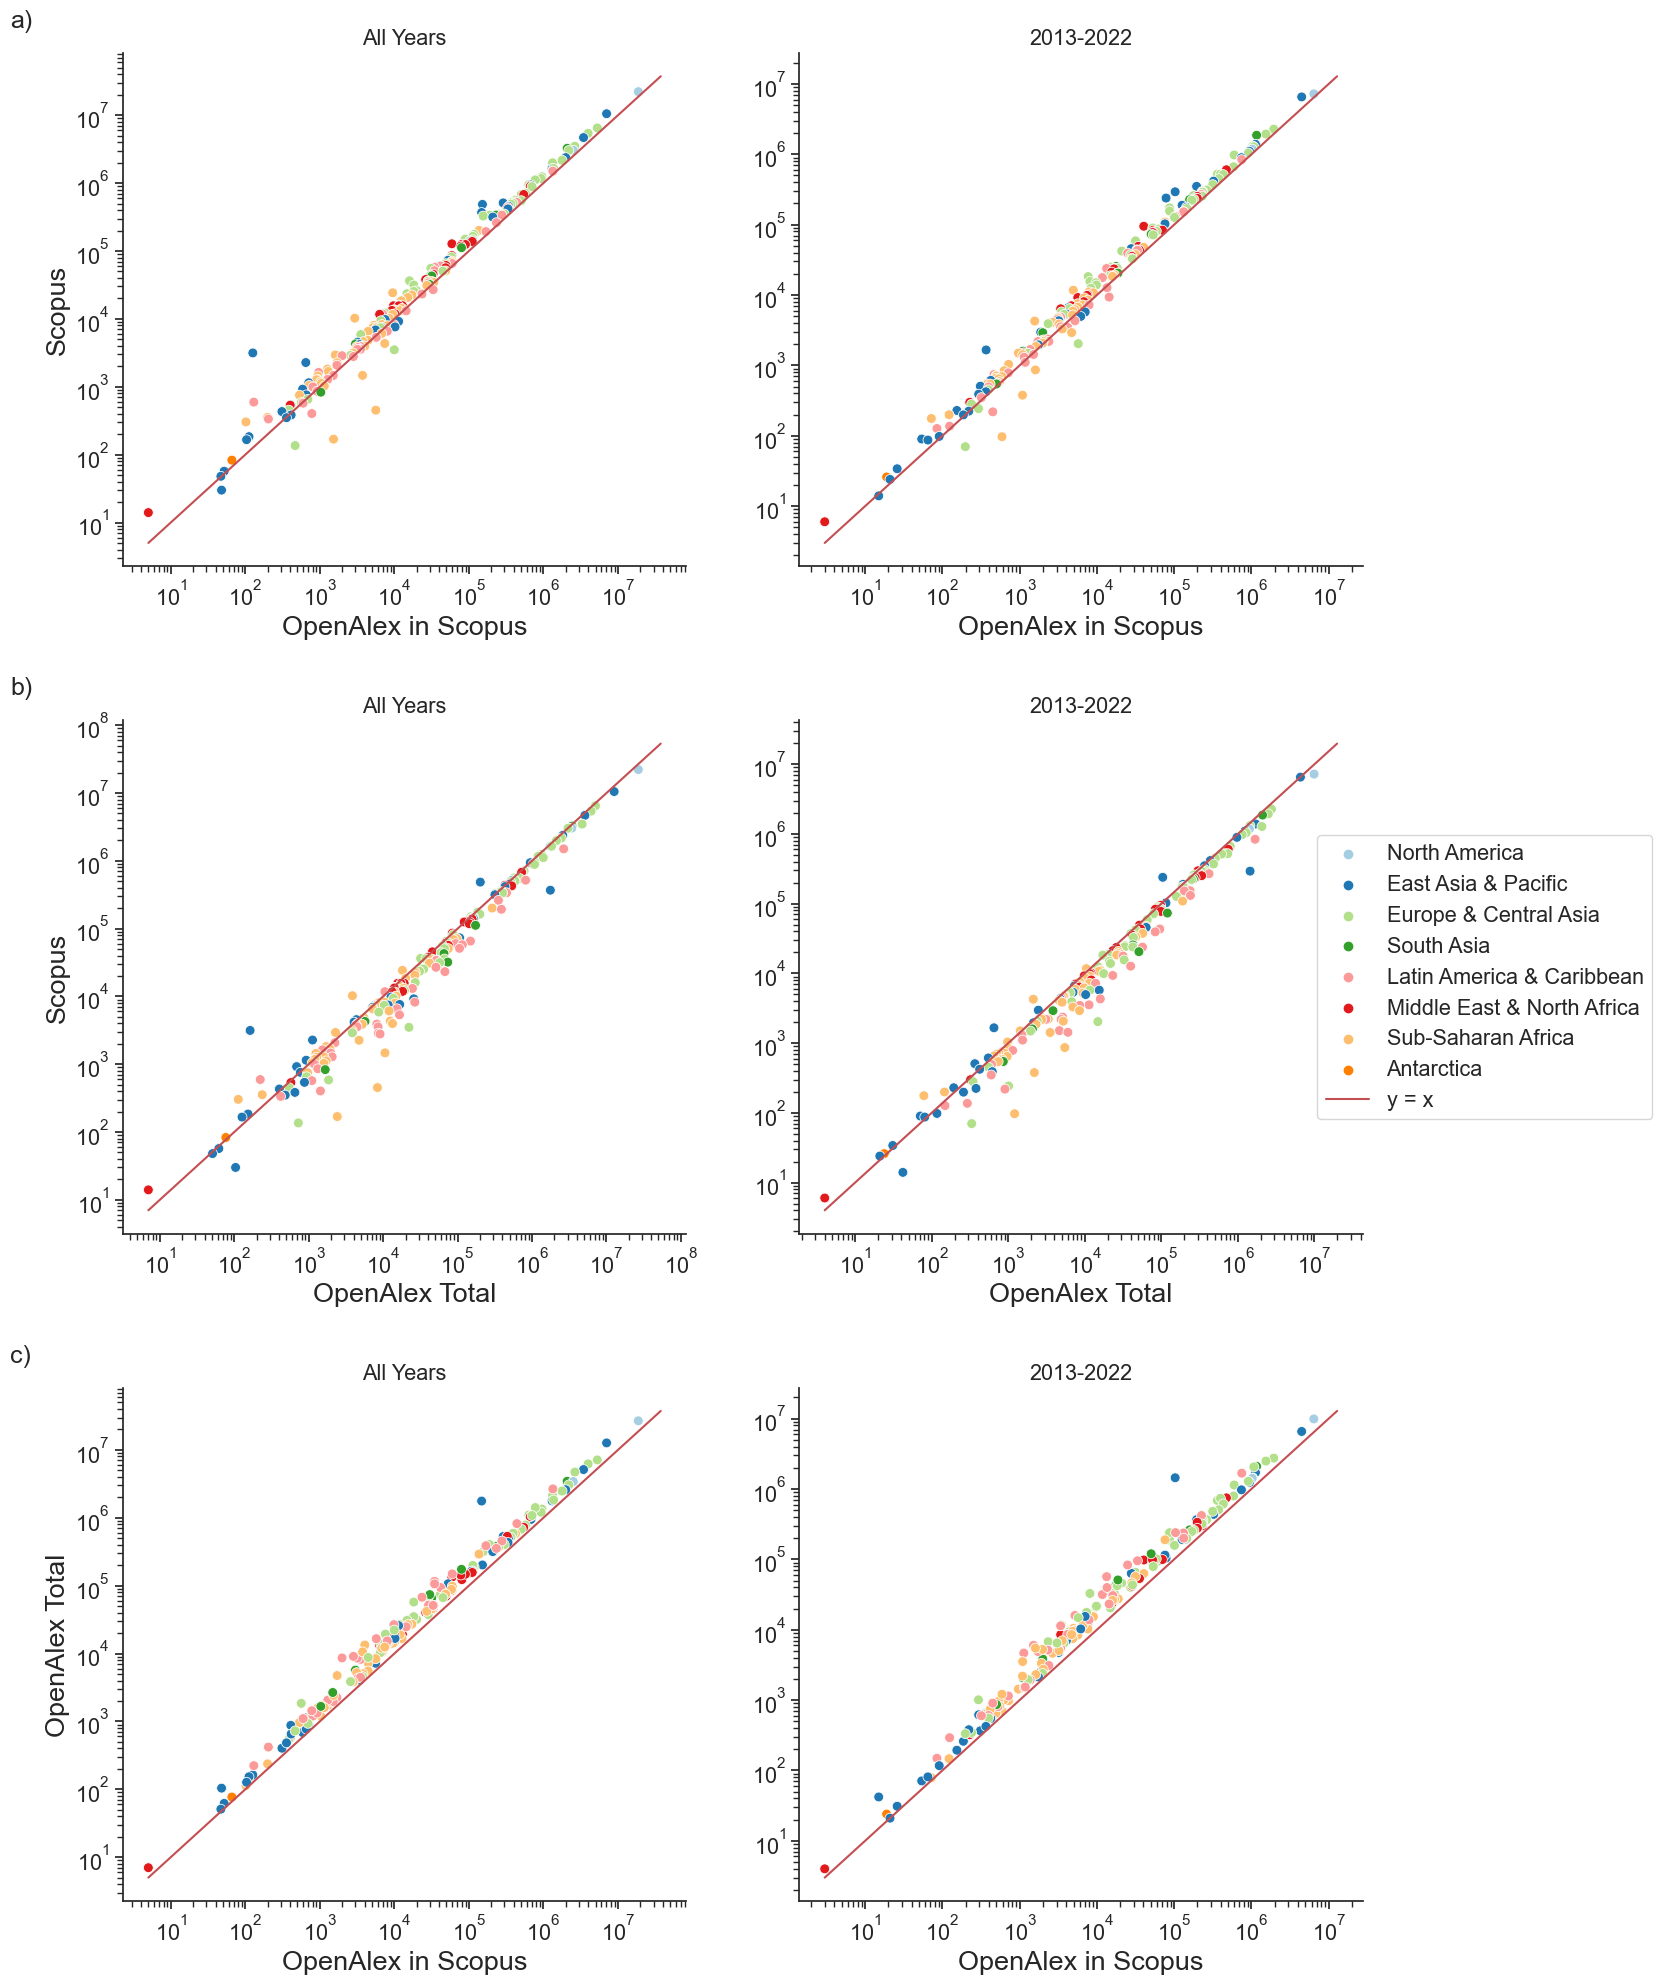

In [27]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
color = sns.color_palette("Paired")

all_years = False
var = 'openalex_in_scopus'

fig, axes = plt.subplots(3, 2, figsize=(16, 24))

for i in range(3):    
    for j in range(2):
        if i == 0:
            var1 = 'openalex_in_scopus'
            var2 = 'scopus'
        elif i == 1:
            var1 = 'openalex_total'
            var2 = 'scopus'
        elif i == 2: 
            var1 = 'openalex_in_scopus'
            var2 = 'openalex_total'
        
        ax = axes[i][j]
        
        if j == 0: 
            data = prepare_countries(oa_country_all, sc_country_all)
            ax.set_title('All Years', fontsize=12*font_scale) 
            # ax.set_ylabel('Scopus')
        else:
            data = prepare_countries(oa_country_last10, sc_country_last10)
            ax.set_title('2013-2022', fontsize=12*font_scale)            
    
        data = data[data[var1] > 0]  # for OpenAlex: only Yugoslavia not matched 
        data = data[data[var2] > 0]  # for Scopus: only Kosovo and Bhutan
        # data[var1] = data[var1].add(1)
        # data[var2] = data[var2].add(1)
        data.drop('_no_country', inplace=True)
        # data.drop('Unknown', inplace=True)
    
        sns.scatterplot(data=data, x=var1, y=var2, hue='Region', s=50, palette=color[:data.Region.unique().shape[0]], ax=ax)    
        ax.set(yscale="log")
        ax.set(xscale="log")

        ylim = ax.get_ylim()
        xlim = ax.get_xlim()

        log_x = np.log(data[var1])
        log_y = np.log(data[var2])
    
        # Fit the OLS model
        # Add a constant to the independent variable (for intercept)
        # X = sm.add_constant(log_x)
        # model = sm.OLS(log_y, X).fit()
    
        # # Get the intercept and coefficients
        # intercept = model.params['const']
        # slope = model.params[var1]
    
        # # Calculate the regression line in log-log space
        # regression_line_loglog = slope * log_x + intercept
    
        # Plot the regression line (log-log)
        # ax.loglog(np.exp(log_x), np.exp(regression_line_loglog), 'r-', label='Linear regression line')
        # ax.loglog(np.exp([10,data[var1].max()]), np.exp([10,data[var1].max()]), 'r-', label='y = x')
        ax.plot([data[var1].min(), data[var1].max()*2], [data[var1].min(), data[var1].max()*2], 'r-', label='y = x')
        # ax.set_ylim([10, data[var2].max()])
        # ax.set_xlim([10, data[var1].max()])
        
        ax.set_xlabel(var1.replace('_', ' ').title().replace('Openalex', 'OpenAlex').replace('In', 'in'))
        ax.set_ylabel(var2.replace('_', ' ').title().replace('Openalex', 'OpenAlex').replace('In', 'in'))        

        print(data[data.Region == 'Unknown'].index)        
        
        ax.get_legend().remove()
        if (i == j == 1) : 
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(bbox_to_anchor=(.9, 0.5), loc='center left')

        if j == 0:
            ax.text(-0.2, 1.05, '{})'.format('abc'[i]), transform=ax.transAxes, size=18)
        
        if j == 1:
            ax.set_ylabel('')
            
            
plt.subplots_adjust(hspace=0.3) 
plt.savefig('figures/Figure 5. Comparison of countries by region.png'.format(var, 'all' if all_years else 'last10'), bbox_inches='tight')

# print(intercept)
# print(coefficients)
# model.summary()

In [28]:
df = prepare_countries(oa_country_last10, sc_country_last10)
# df = df[df['scopus'] > 0]
# df = df[df[var] > 0]  # TODO: what to do with YUGOSLAVIA
df.drop('_no_country', inplace=True)


print('Countries (2013-2022): Spearman Correlation')
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman').to_clipboard()
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman')



Countries (2013-2022): Spearman Correlation


,openalex_in_scopus,openalex_total,scopus
openalex_in_scopus,1.000000,0.993801,0.989246
openalex_total,0.993801,1.000000,0.983395
scopus,0.989246,0.983395,1.000000


In [29]:
df = prepare_countries(oa_country_all, sc_country_all)
df.drop('_no_country', inplace=True)


print('Countries (All Years): Spearman Correlation')
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman')

Countries (All Years): Spearman Correlation


,openalex_in_scopus,openalex_total,scopus
openalex_in_scopus,1.000000,0.995044,0.974632
openalex_total,0.995044,1.000000,0.969495
scopus,0.974632,0.969495,1.000000


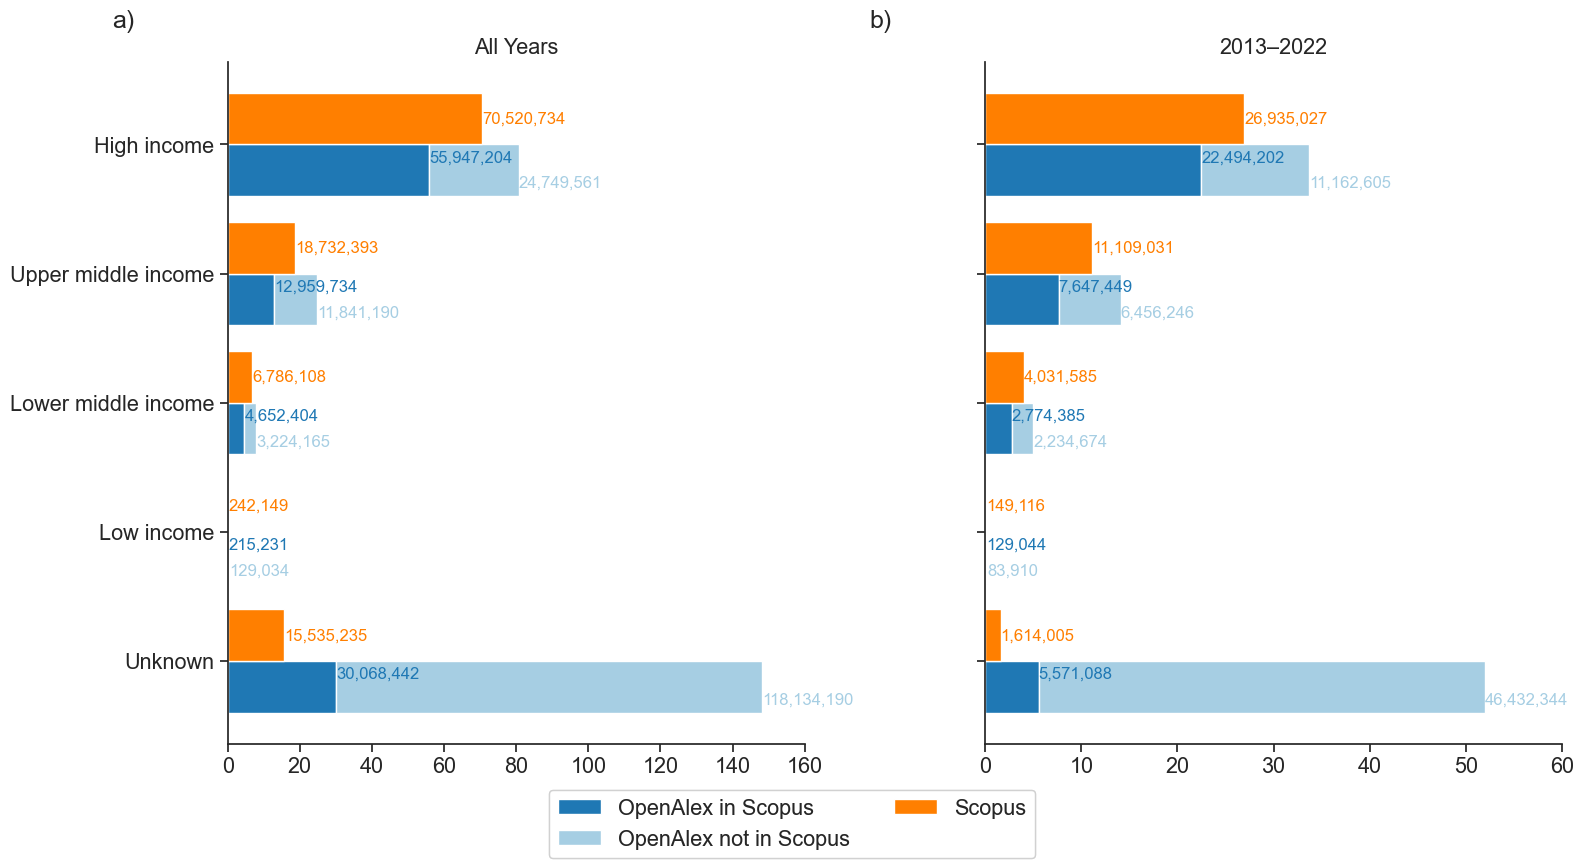

In [30]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
color = sns.color_palette("Paired")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, ax in enumerate(axes.reshape(-1)):
    if i == 0: 
        df = prepare_countries(oa_country_all, sc_country_all)
        ax.set_title('All Years', fontsize=12*font_scale)
    else:
        df = prepare_countries(oa_country_last10, sc_country_last10)
        ax.set_title('2013–2022', fontsize=12*font_scale)      
    
#     df.drop(index='_no_country', inplace=True)  
#     df = df.nlargest(top, columns=['openalex_no_scopus'])
#     df['Income group'].fillna('Unknown Country', inplace=True)

    df = df.groupby('Income group').sum()
    df = df.reindex(['Unknown', 'Low income', 'Lower middle income', 'Upper middle income', 'High income'])
    
    width = .8  # the width of the bars

    # Create bars for each group
    bars1 = ax.barh([2*x-1-width/2 for x in range(1,df.shape[0]+1)], df['openalex_in_scopus'], width, label='OpenAlex in Scopus', color=color[1])   
    bars2 = ax.barh([2*x-1-width/2 for x in range(1,df.shape[0]+1)], df['openalex_no_scopus'], width, left=df['openalex_in_scopus'], label='OpenAlex not in Scopus', color=color[0])
    bars3 = ax.barh([2*x-1+width/2 for x in range(1,df.shape[0]+1)], df['scopus'], width, label='Scopus', color=color[7])

    for bar1, label1, bar2, label2 in zip(bars1, df['openalex_in_scopus'], bars2, df['openalex_no_scopus']):
        ax.text(bar1.get_width(), bar1.get_y() + bar1.get_height() / 4*3, "{:,.0f}".format(label1),
                 ha='left', va='center', color=color[1])
        ax.text(bar1.get_width() + bar2.get_width(), bar2.get_y() + bar2.get_height() / 4, "{:,.0f}".format(label2),
                 ha='left', va='center', color=color[0])
        
    for bar, label in zip(bars3, df['scopus']):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, "{:,.0f}".format(label),
                 ha='left', va='center', color=color[7])

    
    ax.set_yticks(np.arange(1, df.shape[0]*2+1, 2))
    ax.set_yticklabels(df.index)
    
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(['{:,.0f}'.format(x/1000000) for x in ax.get_xticks()])
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(.5, 0.02), ncol=2, loc='upper center')
    
    if i == 1: 
        ax.set_yticklabels([])        

    text_labels = [child for child in ax.get_children() if isinstance(child, plt.Text)]
    
    ax.text(-0.2, 1.05, '{})'.format('abc'[i]), transform=ax.transAxes, size=18)

    
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0)



plt.tight_layout()
plt.savefig('figures/Figure 6. Comparison of Countries by Income Group.png', bbox_inches='tight')

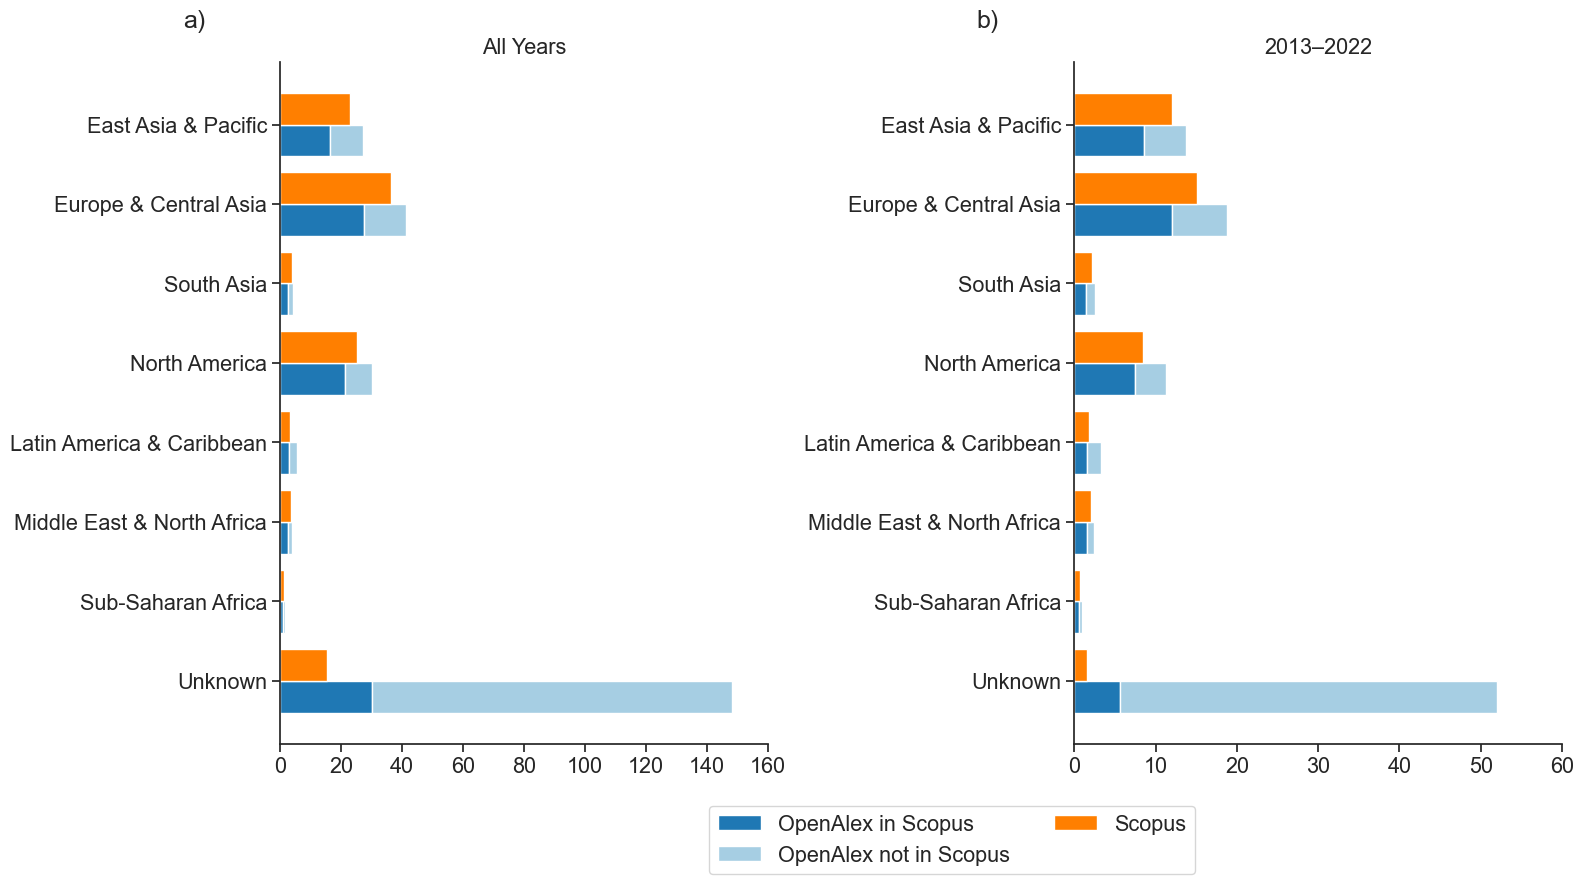

In [31]:
top = 15

font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
color = sns.color_palette("Paired")


fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, ax in enumerate(axes.reshape(-1)):
    if i == 0: 
        df = prepare_countries(oa_country_all, sc_country_all)
        ax.set_title('All Years', fontsize=12*font_scale)
    else:
        df = prepare_countries(oa_country_last10, sc_country_last10)
        ax.set_title('2013–2022', fontsize=12*font_scale)      
    
#     df.drop(index='_no_country', inplace=True)  
#     df = df.nlargest(top, columns=['openalex_no_scopus'])
    df['Region'] = df.Region.fillna('Unknown Country')
    df = df.groupby('Region').sum()
    df = df.reindex(['Unknown', 'Sub-Saharan Africa', 'Middle East & North Africa', 'Latin America & Caribbean', 'North America', 'South Asia', 'Europe & Central Asia', 'East Asia & Pacific'])
      
    width = .8  # the width of the bars

    # Create bars for each group
    bars1 = ax.barh([2*x-1-width/2 for x in range(1,df.shape[0]+1)], df['openalex_in_scopus'], width, label='OpenAlex in Scopus', color=color[1])
    bars2 = ax.barh([2*x-1-width/2 for x in range(1,df.shape[0]+1)], df['openalex_no_scopus'], width, left=df['openalex_in_scopus'], label='OpenAlex not in Scopus', color=color[0])
    bars3 = ax.barh([2*x-1+width/2 for x in range(1,df.shape[0]+1)], df['scopus'], width, label='Scopus', color=color[7])

    # Annotating each bar with its label
    # for bar, label in zip(bars1, df['openalex_in_scopus']):
    #     width = bar.get_width()
    #     ax.text(width+ 100, bar.get_y() + bar.get_height() / 2, "{:,.0f}".format(label),
    #              ha='left', va='center')
       
    ax.set_yticks(np.arange(1, df.shape[0]*2+1, 2))
    ax.set_yticklabels(df.index)
    
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(['{:,.0f}'.format(x/1000000) for x in ax.get_xticks()])

    ax.text(-0.2, 1.05, '{})'.format('abc'[i]), transform=ax.transAxes, size=18)

    
# handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.6, 0.0), ncol=2, loc='upper center')
# plt.legend(bbox_to_anchor=(.02, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig('figures/region_bar.png', bbox_inches='tight')

In [32]:
lang_map = pd.read_excel('field_maps.xlsx', sheet_name='language', engine='openpyxl')
lang_map = lang_map[['language', 'openalex', 'scopus']]

oa_lang_all, oa_lang_last10 = read_openalex('language')
sc_lang_all, sc_lang_last10 = read_scopus('language')

# type_map = pd.read_excel('field_maps.xlsx', sheet_name='language', engine='openpyxl')
# type_map.dropna(inplace=True)
# type_map = pd.Series(type_map.openalex.values,index=type_map.scopus).to_dict()

# oa_lang_all = pd.read_excel('Inscopus Paratext Compare.xlsx', index_col='language', sheet_name='language_all_years', engine='openpyxl')
# sc_lang_all = scopus_all[['language', 'language_n']].dropna(0)
# sc_lang_all.set_index('language', inplace=True)

# oa_lang_last10 = pd.read_excel('Inscopus Paratext Compare.xlsx', index_col='language', sheet_name='language_2013-2022', engine='openpyxl')
# sc_lang_last10 = scopus_last10[['language', 'language_n']].dropna(0)
# sc_lang_last10.set_index('language', inplace=True)

In [33]:
def prepare_lang(oa, sc): 
    oa = oa.copy(deep=True)
    sc = sc.copy(deep=True)

    lmap = lang_map[['language', 'openalex']].drop_duplicates()
    lmap = pd.Series(lmap.language.values,index=lmap.openalex).to_dict()
    oa.index = oa.index.map(lambda x: lmap[x])
    oa = oa.reset_index().groupby('language').sum()
    
    lmap = lang_map[['language', 'scopus']].drop_duplicates().dropna()
    lmap = pd.Series(lmap.language.values,index=lmap.scopus).to_dict()
    sc.index = sc.index.map(lambda x: lmap[x])
    sc = sc.reset_index().groupby('language').sum()
 
    df = oa.merge(sc, how='outer', left_index=True, right_index=True).fillna(0)
    df.columns = ['openalex_no_scopus', 'openalex_in_scopus', 'openalex_total', 'scopus']
    df = df.sort_values('scopus', ascending=False)
#     del df['openalex_total']

    return df


### Rank Correlation in languages 

In [34]:
df = prepare_lang(oa_lang_last10, sc_lang_last10)

print('Languages (2013–2022)')
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman').to_clipboard()
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman')

Languages (2013–2022)


,openalex_in_scopus,openalex_total,scopus
openalex_in_scopus,1.000000,0.954324,0.820858
openalex_total,0.954324,1.000000,0.772408
scopus,0.820858,0.772408,1.000000


In [35]:
df = prepare_lang(oa_lang_all, sc_lang_all)

print('Languages (All Years)')
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman').to_clipboard()
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman')

Languages (All Years)


,openalex_in_scopus,openalex_total,scopus
openalex_in_scopus,1.000000,0.956163,0.759137
openalex_total,0.956163,1.000000,0.752535
scopus,0.759137,0.752535,1.000000


### Langs in OpenAlex and NOT in Scopus

In [36]:
df[df.scopus == 0].sort_values('openalex_total', ascending=False)

,openalex_no_scopus,openalex_in_scopus,openalex_total,scopus
language,,,,
Somali,70082.0,20865.0,90947.0,0.0
Swahili,32883.0,5015.0,37898.0,0.0
Tamil,3545.0,0.0,3545.0,0.0
Marathi,3220.0,0.0,3220.0,0.0
Nepali,2936.0,6.0,2942.0,0.0
Gujarati,345.0,0.0,345.0,0.0
Kannada,183.0,0.0,183.0,0.0
Telugu,58.0,0.0,58.0,0.0
Panjabi; Punjabi,46.0,1.0,47.0,0.0


### Langs in Scopus and NOT in OpenAlex

In [37]:
df[df.openalex_total == 0]['scopus']

language
Serbian            40457.0
Bosnian             7973.0
Icelandic           2834.0
Azerbaijani         1356.0
Latin                190.0
Irish Gaelic         173.0
Esperanto            170.0
Basque               142.0
Georgian             140.0
Belarusian            75.0
Armenian              70.0
Mongolian             21.0
Kazakh                15.0
Scottish Gaelic       11.0
Pushto                 4.0
Sinhalese              3.0
Uzbek                  2.0
Name: scopus, dtype: float64

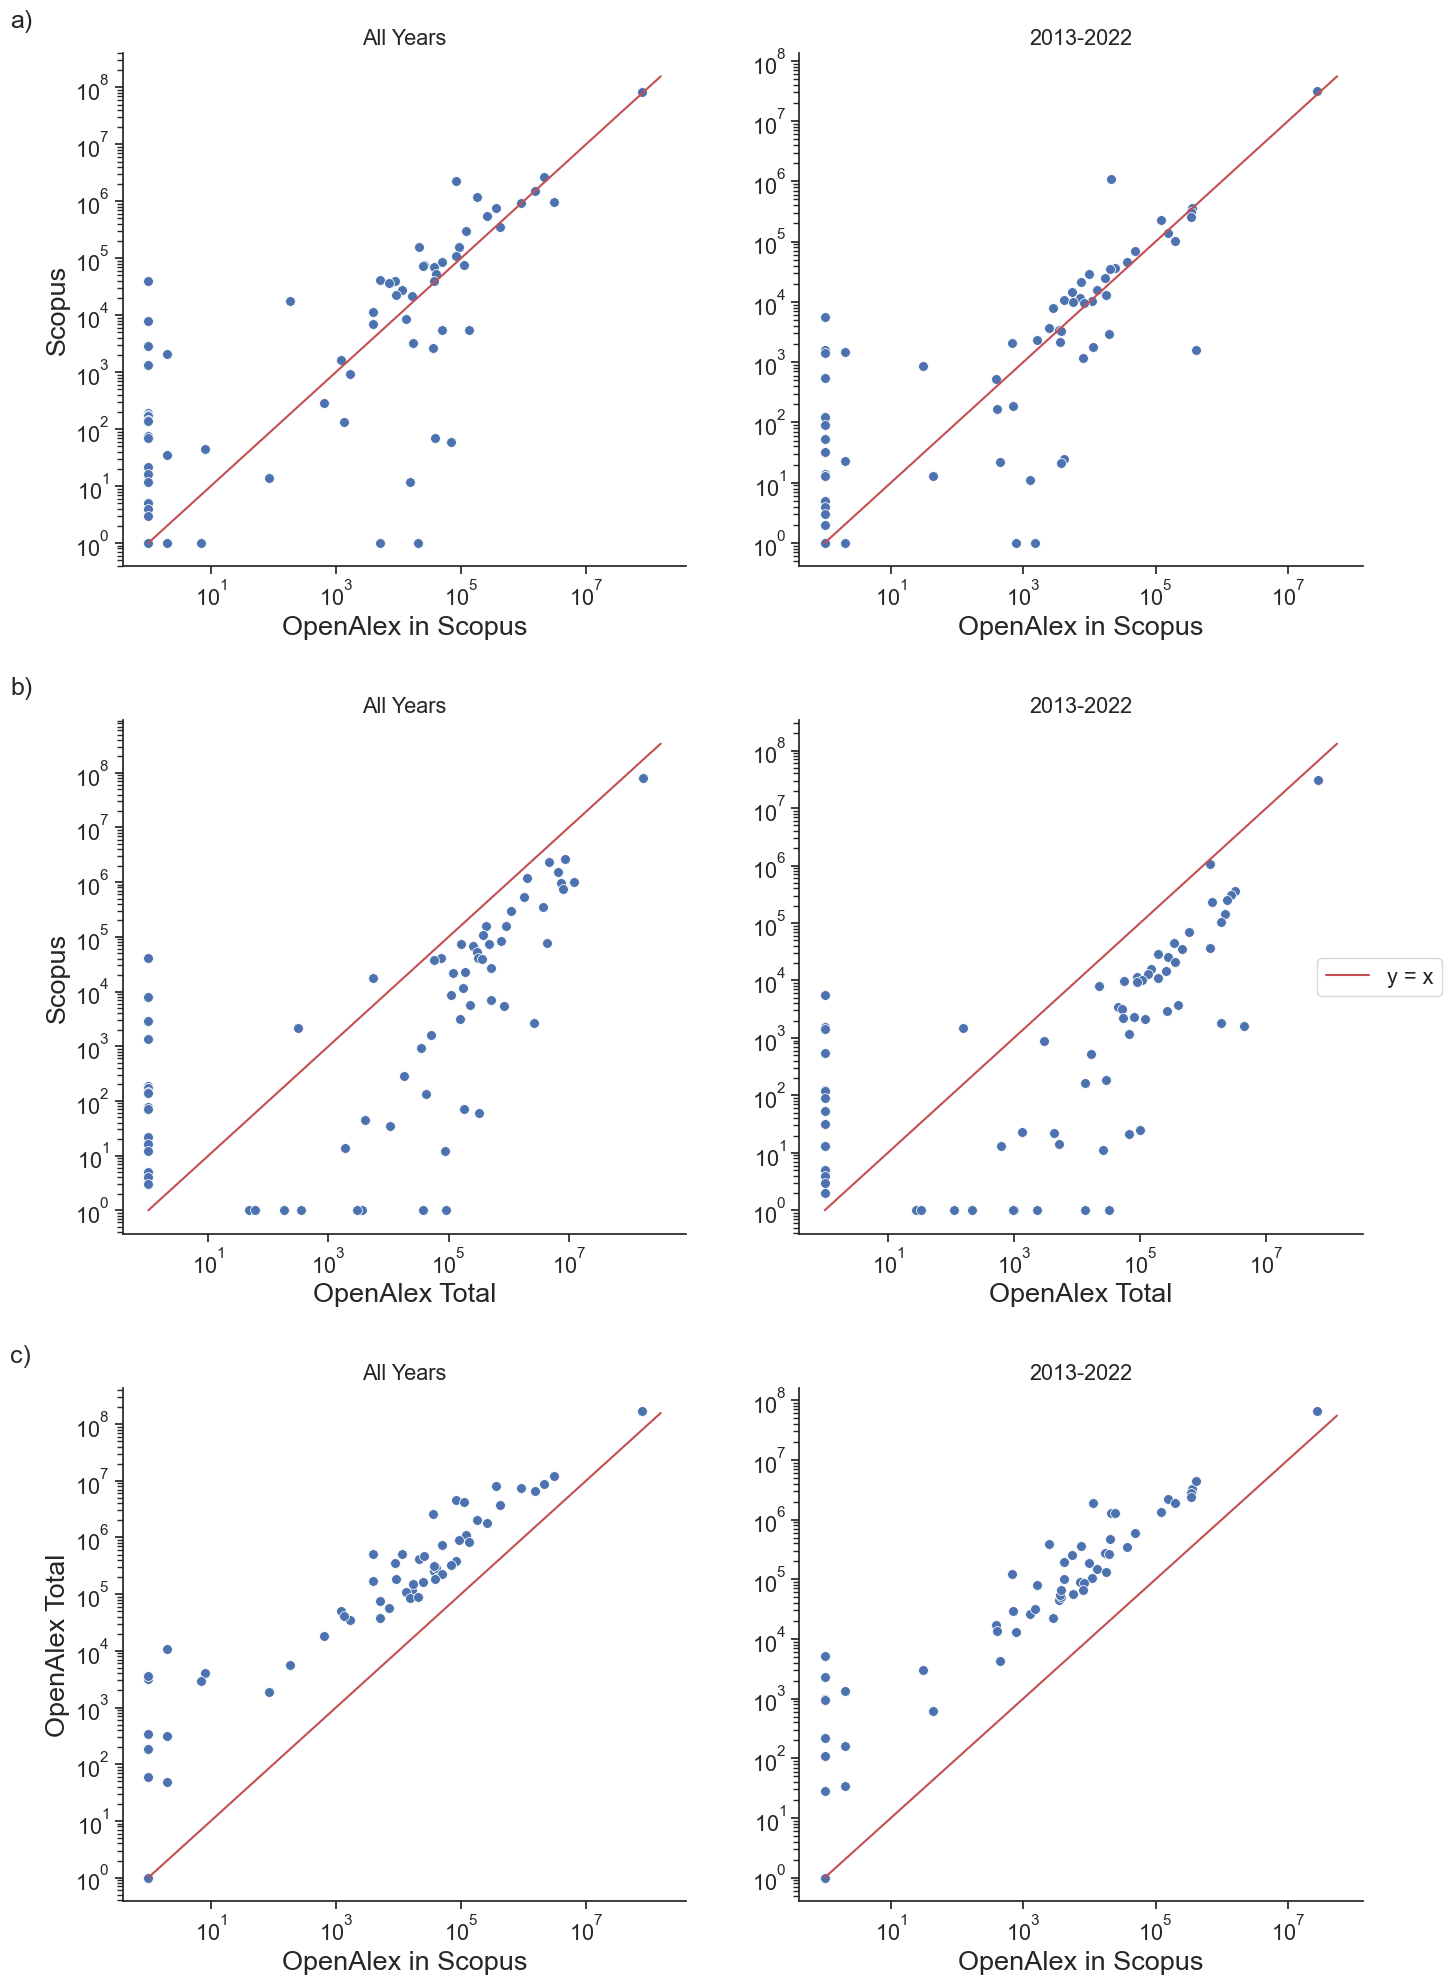

In [38]:
all_years = True
var = 'openalex_total'

fig, axes = plt.subplots(3, 2, figsize=(16, 24))


for i in range(3):    
    for j in range(2):
        if i == 0:
            var1 = 'openalex_in_scopus'
            var2 = 'scopus'
        elif i == 1:
            var1 = 'openalex_total'
            var2 = 'scopus'
        elif i == 2: 
            var1 = 'openalex_in_scopus'
            var2 = 'openalex_total'
        
        ax = axes[i][j]

        if j == 0: 
            data = prepare_lang(oa_lang_all, sc_lang_all)        
            ax.set_title('All Years', fontsize=12*font_scale) 
        else:
            data = prepare_lang(oa_lang_last10, sc_lang_last10)        
            ax.set_title('2013-2022', fontsize=12*font_scale)    
           
        # data = data[data[var1] > 0]  
        # data = data[data[var2] > 0]  
        data[var1] = data[var1].add(1)
        data[var2] = data[var2].add(1)
        # data.drop('_no_country', inplace=True)
    
        sns.scatterplot(data=data, x=var1, y=var2, s=50, ax=ax)    
        ax.set(yscale="log")
        ax.set(xscale="log")

        ylim = ax.get_ylim()
        xlim = ax.get_xlim()

        log_x = np.log(data[var1])
        log_y = np.log(data[var2])
    
        # Fit the OLS model
        # Add a constant to the independent variable (for intercept)
        X = sm.add_constant(log_x)
        model = sm.OLS(log_y, X).fit()
    
        # Get the intercept and coefficients
        intercept = model.params['const']
        slope = model.params[var1]
    
        # Calculate the regression line in log-log space
        regression_line_loglog = slope * log_x + intercept
    
        # Plot the regression line (log-log)
        # ax.loglog(np.exp(log_x), np.exp(regression_line_loglog), 'r-', label='Linear regression line')
        # ax.set_ylim([10, data[var2].max()+1000])
        # ax.set_xlim([10, data[var1].max()+1000])
        ax.plot([data[var1].min(), data[var1].max()*2], [data[var1].min(), data[var1].max()*2], 'r-', label='y = x')        
        ax.set_xlabel(var1.replace('_', ' ').title().replace('Openalex', 'OpenAlex').replace('In', 'in'))
        ax.set_ylabel(var2.replace('_', ' ').title().replace('Openalex', 'OpenAlex').replace('In', 'in'))        
        
        # ax.get_legend().remove()
        if (i == j == 1) : 
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(bbox_to_anchor=(.9, 0.5), loc='center left')            

        if j == 0:
            ax.text(-0.2, 1.05, '{})'.format('abc'[i]), transform=ax.transAxes, size=18)
            
        if j == 1:
            ax.set_ylabel('')

plt.subplots_adjust(hspace=0.3) 
plt.savefig('figures/Figure 8. Comparison of languages.png'.format(var, 'all' if all_years else 'last10'), bbox_inches='tight')

In [39]:
def read_openalex_citations(field): 
    if field == 'refs': 
        all_years = pd.read_excel('OpenAlexCitations.xlsx', sheet_name='referenced_works_count_all_year', engine='openpyxl')
        last10 = pd.read_excel('OpenAlexCitations.xlsx', sheet_name='referenced_2013-2022', engine='openpyxl')
    elif field == 'cits':
        all_years = pd.read_excel('OpenAlexCitations.xlsx', sheet_name='cited_by_count_all_years', engine='openpyxl')
        last10 = pd.read_excel('OpenAlexCitations.xlsx', sheet_name='cited_by_c_2013-2022', engine='openpyxl')
        
        
    all_years = all_years.set_index('countries').dropna()
    last10 = last10.set_index('countries').dropna()

    return all_years, last10



In [41]:
refs_by_country_all, refs_by_country_last10 = read_openalex_citations('refs')
cits_by_country_all, cits_by_country_last10 = read_openalex_citations('cits')

scopus_citations = pd.read_excel('ScopusCitations.xlsx', engine='openpyxl').iloc[:,:3].dropna()
scopus_citations.columns = ['country', 'works', 'total']
scopus_citations.set_index('country', inplace=True)
del scopus_citations['works']


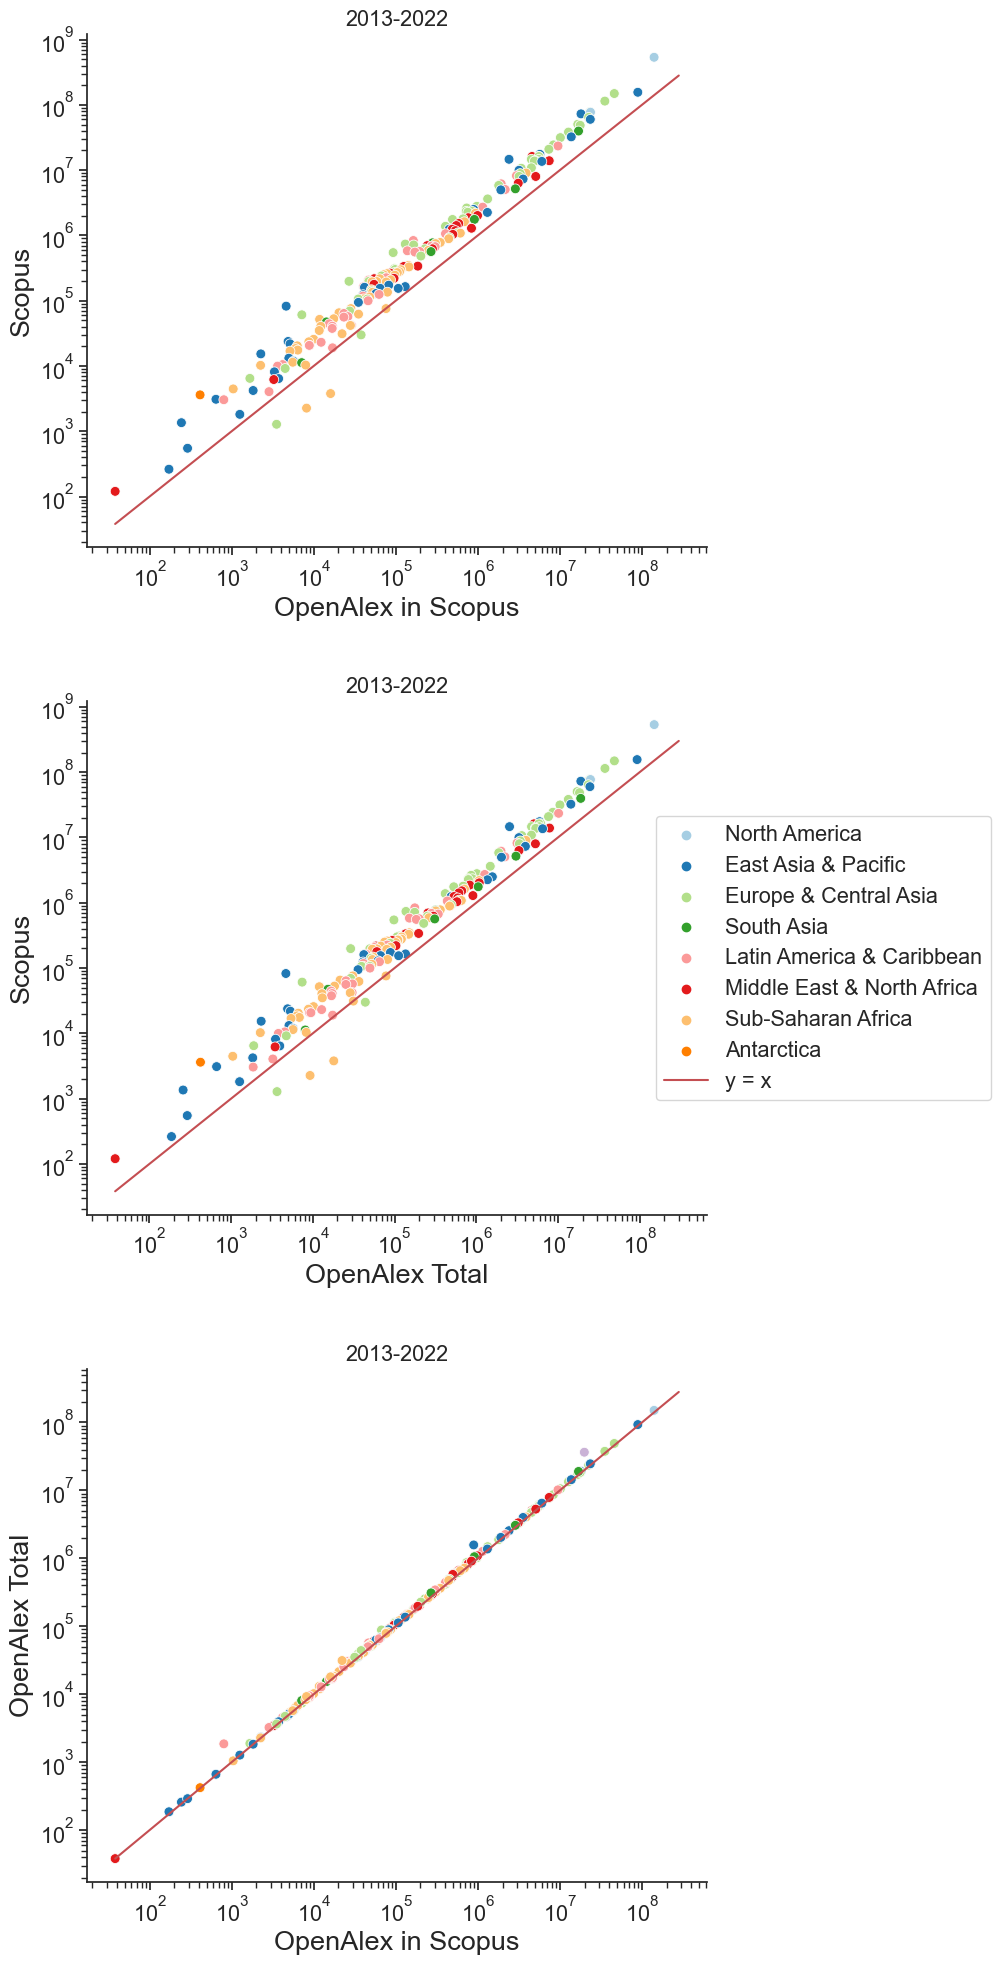

In [42]:
font_scale = 1.3
custom_params = {"axes.spines.right": False, 
                    "axes.spines.top": False, 
                    'axes.labelsize': 15 * font_scale, 
                    'axes.titlesize': 18 *font_scale,   
                    'xtick.labelsize': 12 * font_scale,  
                    'ytick.labelsize': 12 * font_scale,  
                    'legend.fontsize': 12 * font_scale  
                }
sns.set_theme(style="ticks", rc=custom_params)
color = sns.color_palette("Paired")

all_years = False
var = 'openalex_in_scopus'

fig, axes = plt.subplots(3, 1, figsize=(8, 24))

for i in range(3):    
    if i == 0:
        var1 = 'openalex_in_scopus'
        var2 = 'scopus'
    elif i == 1:
        var1 = 'openalex_total'
        var2 = 'scopus'
    elif i == 2: 
        var1 = 'openalex_in_scopus'
        var2 = 'openalex_total'
    
    ax = axes[i]
    
    data = prepare_countries(cits_by_country_last10, scopus_citations)
    ax.set_title('2013-2022', fontsize=12*font_scale)            

    data = data[data[var1] > 0]  # for OpenAlex: only Yugoslavia not matched 
    data = data[data[var2] > 0]  # for Scopus: only Kosovo and Bhutan
    # data[var1] = data[var1].add(1)
    # data[var2] = data[var2].add(1)
    # data.drop('_no_country', inplace=True)

    scatter = sns.scatterplot(data=data, x=var1, y=var2, hue='Region', s=50, palette=color[:data.Region.unique().shape[0]], ax=ax)    
    ax.set(yscale="log")
    ax.set(xscale="log")

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    log_x = np.log(data[var1])
    log_y = np.log(data[var2])

    # Fit the OLS model
    # Add a constant to the independent variable (for intercept)
    # X = sm.add_constant(log_x)
    # model = sm.OLS(log_y, X).fit()

    # # Get the intercept and coefficients
    # intercept = model.params['const']
    # slope = model.params[var1]

    # # Calculate the regression line in log-log space
    # regression_line_loglog = slope * log_x + intercept
    # residuals = log_y - regression_line_loglog
    # # Calculate standard deviation of residuals
    # std_residuals = np.std(residuals)
    
    # # Identify points more than 3 standard deviation away from the linear relationship
    # threshold = 3 * std_residuals  # Adjust as needed
    
    # Identify points more than the threshold away from the linear relationship
    # outlier_indices = np.where(np.abs(residuals) > threshold)[0]    

    # texts = []
    # for outlier in outlier_indices:
    #     name = data.iloc[outlier].name
    #     x = data.iloc[outlier][var1]
    #     y = data.iloc[outlier][var2]

    #     name = name.replace(' and', '\nand')
    #     texts.append(ax.text(x, y, name))


    # adjust_text(texts, ax=ax, avoid=ax.get_children(), only_move={'points':'y', 'texts':'y'})
        # ax.annotate(f'{name}', (x, y), textcoords="offset points", xytext=(offsetx,offsety), ha='center')

    # Plot the regression line (log-log)
    # ax.loglog(np.exp(log_x), np.exp(regression_line_loglog), 'r-', label='Linear regression line')
    # ax.set_ylim([10, data[var2].max()])
    # ax.set_xlim([10, data[var1].max()])
    ax.plot([data[var1].min(), data[var1].max()*2], [data[var1].min(), data[var1].max()*2], 'r-', label='y = x')    
    ax.set_xlabel(var1.replace('_', ' ').title().replace('Openalex', 'OpenAlex').replace('In', 'in'))
    ax.set_ylabel(var2.replace('_', ' ').title().replace('Openalex', 'OpenAlex').replace('In', 'in'))        
    
    ax.get_legend().remove()
    if (i == 1) : 
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(bbox_to_anchor=(.9, 0.5), loc='center left')            

    
    # if j == 1:
    #     ax.set_ylabel('')

            
plt.subplots_adjust(hspace=0.3) 
plt.savefig('figures/Figure 7. Comparison of Citations by Countries and Region.png'.format(var, 'all' if all_years else 'last10'), bbox_inches='tight')

# print(intercept)
# print(coefficients)
# model.summary()

In [43]:
df = prepare_countries(cits_by_country_last10, scopus_citations)

print('Citations (2013–2022)')
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman').to_clipboard()
df[['openalex_in_scopus', 'openalex_total', 'scopus']].corr(method='spearman')

Citations (2013–2022)


,openalex_in_scopus,openalex_total,scopus
openalex_in_scopus,1.000000,0.999642,0.957315
openalex_total,0.999642,1.000000,0.955851
scopus,0.957315,0.955851,1.000000
